# Homeworks 3 and 4
Student: Grigoryev Mikhail

Group: J4133c

## Customer

In [1]:
class CustomerQueue:
    def __init__(self, i):
        self.q = []
        self.i = i

    def length(self):
        return len(self.q)

    def pop(self):
        return self.q.pop(0)

    def append(self, cid):
        self.q.append(cid)

## Events queue

In [2]:
# Queue of Events
class EventsQueue:
    def __init__(self):
        self.globalTime = 0
        self.MEvents = []

    def QueueSize(self):
        return len(self.MEvents)

    def AddEvent(self, MEvent):
        count = len(self.MEvents)
        if count == 0:
            self.MEvents.append(MEvent)
            return 0

        if (MEvent.eTime >= self.MEvents[count - 1].eTime):
            self.MEvents.append(MEvent)
            return 0

        for i in range(0, count - 1):
            if (MEvent.eTime >= self.MEvents[i].eTime):
                if (MEvent.eTime < self.MEvents[i + 1].eTime):
                    self.MEvents.insert(i + 1, MEvent)
                    return 0

    def ProcessNextEvent(self):
        if (len(self.MEvents) == 0):
            return 0
        self.MEvents[0].Execute()
        self.globalTime = self.MEvents[0].eTime
        del self.MEvents[0]

## Customer stat

In [3]:
class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0

## System

In [4]:
class DEVS:
    EQ = EventsQueue()
    GlobalTime = 0.0

    def __init__(self, n_cashiers=5):
        # Parameters
        self.stats = []
        self.newId = 0
        self.lastServedTime = 0
        self.GlobalTime = 0.0
        self.nCashiers = n_cashiers
        self.queueHistory = []
        self.work_cashiers = []

        # Queues
        self.EQ = EventsQueue()
        self.CQ = CustomerQueue(0)

        # Cashiers
        # (isIdle, isOpen) for cashier in nCashiers
        self.CASH = [(True, True) for _ in range(self.nCashiers)]
        # close the last cashier for now
        self.CASH[self.nCashiers - 1] = (True, False)

    def ProcessNextEvent(self):
        self.EQ.ProcessNextEvent()
        self.work_cashiers.append(len([c for c in self.CASH if c[1]]))
        self.GlobalTime = self.EQ.globalTime

    def isCashierFree(self, id): return self.CASH[id]
    def isAnyCashierFree(self): return len([c for c in self.CASH if c[0]]) > 0
    def randomFreeCashier(self): return random.choice([i for i, c in enumerate(self.CASH) if c[0]])

    def markCashierAsBusy(self, id):
        if not self.CASH[id][0]: raise KeyError('Cashier is already busy')
        self.CASH[id] = (False, self.CASH[id][1])

    def markCashierAsFree(self, id):
        if self.CASH[id][0]: raise KeyError('Cashier is already free')
        self.CASH[id] = (True, self.CASH[id][1])

    def openCashier(self):
        for i, c in enumerate(self.CASH):
            if not c[1]:
                self.CASH[i] = (c[0], True)
                return

        raise KeyError('Nothing to open')

    def closeCashier(self):
        for i, c in enumerate(self.CASH):
            if c[1]:
                self.CASH[i] = (c[0], False)
                return

        raise KeyError('Nothing to close')

    def manageCashiers(self):
        len_busy_cashiers = len([c for c in self.CASH if not c[0]])
        len_open_cashiers = len([c for c in self.CASH if c[1]])
        len_free_cashiers = len([c for c in self.CASH if c[0] and c[1]])

        if len_open_cashiers > 4 and len_free_cashiers > 0:
            self.closeCashier()

        if len_busy_cashiers == 4 and len_open_cashiers == 4:
            self.openCashier()

    def appendCustomer(self, customerId): self.CQ.append(customerId)
    def nextCustomer(self): return self.CQ.pop()
    def lenOfQueue(self): return self.CQ.length()

## Main classes

In [5]:
# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = S.newId
        customer.arrivalTime = self.eTime
        if len(S.stats) > 0:
            customer.interArrivalTime = customer.arrivalTime - S.stats[-1].arrivalTime

        if TOPRINT:
            print("Time %d" % self.eTime, " Arrival Event of agent {0}".format(customer.id))
        if S.newId < maxAngents - 1:
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + arrival_rate.rvs()
            S.EQ.AddEvent(NextArrival)

        # open or close cashiers when needed
        S.manageCashiers()

        # if there are free cashiers we begin the service
        if S.isAnyCashierFree():
            # getting a random free cashier queue
            qid = S.randomFreeCashier()
            S.markCashierAsBusy(qid)
            if TOPRINT:
                print(f'Cashier #{qid} is busy')

            Service = ServiceEvent(qid)
            serviceTime = custm.rvs()

            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time

            Service.eTime = self.eTime + serviceTime
            Service.id = customer.id

            S.EQ.AddEvent(Service)
        else:
            # increase waiting line
            S.appendCustomer(customer.id)
            if TOPRINT:
                print(f'For customer queue line length is {S.lenOfQueue()}')

        S.queueHistory.append(S.lenOfQueue())
        S.newId = S.newId + 1
        S.stats.append(customer)


# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self, c_id):
        self.eTime = 0.0
        self.id = 0
        self.cashier_id = c_id

    def Execute(self):
        ind = [i for i, val in enumerate(S.stats) if val.id == self.id][0]
        S.stats[ind].serviceEnds = self.eTime
        S.stats[ind].timeInSystem = S.stats[ind].serviceEnds - S.stats[ind].arrivalTime
        S.stats[ind].waitingTimeInQueue = S.stats[ind].serviceBegins - S.stats[ind].arrivalTime  # 0 without queue
        if S.stats[ind].serviceBegins - S.lastServedTime > 0:
            S.stats[ind].idleTimeOfServer = S.stats[ind].serviceBegins - S.lastServedTime
        else:
            S.stats[ind].idleTimeOfServer = 0

        if TOPRINT:
            print(f"Time {self.eTime} Service of cashier #{self.cashier_id} finished")

        if S.lenOfQueue() > 0:
            customer_id = S.nextCustomer()
            qind = [i for i, val in enumerate(S.stats) if val.id == customer_id][0]

            Service = ServiceEvent(self.cashier_id)
            serviceTime = custm.rvs()

            Service.eTime = self.eTime + serviceTime
            Service.id = customer_id

            S.stats[qind].serviceBegins = self.eTime
            S.stats[qind].serviceTime = serviceTime

            S.EQ.AddEvent(Service)
            if TOPRINT:
                print("take new customer from the queue")
        else:
            S.markCashierAsFree(self.cashier_id)
            if TOPRINT:
                print(f"Cashier #{self.cashier_id} is idle")

        S.lastServedTime = self.eTime

## Stats

In [6]:
def statistics(S, plot=False):
    with open('output.csv', 'w') as f:
        f.write(
            "Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server;queueHistory\n")
        for s in S.stats:
            f.write("{0};{1};{2};{3};{4};{5};{6};{7};{8};{9}\n".format(
                s.id, s.interArrivalTime, s.arrivalTime, s.serviceTime,
                s.serviceBegins, s.waitingTimeInQueue, s.serviceEnds,
                s.timeInSystem, s.idleTimeOfServer, S.queueHistory))

    if TOPRINT:
        print("\nLEN S STATS\n", len(S.stats))
    # 1) Average waiting time in queue
    avTimeInQueue = sum([x.waitingTimeInQueue for x in S.stats]) / len(S.stats)
    if TOPRINT:
        print('---------------')
        print("\nAverage waiting time\t{0:.2f}".format(avTimeInQueue))
        print(f'Mean size of queue\t{np.mean(S.queueHistory):.2f}')

    # 2) Probability that a customer has to wait
    probToWait = len([x for x in S.stats if x.waitingTimeInQueue > 0]) / len(S.stats)
    if TOPRINT:
        print("Probability that a customer has to wait\t{0:.2f}".format(probToWait))

    # 3) Probability of an Idle server
    probIdle = sum([x.idleTimeOfServer for x in S.stats]) / S.GlobalTime
    if TOPRINT:
        print("Probability of an Idle server\t{0:.2f}".format(probIdle))

    # 4) Average service time (theoretical 3.2)
    avServiceTime = sum([x.serviceTime for x in S.stats]) / len(S.stats)
    if TOPRINT:
        print("Average service time\t{0:.2f}".format(avServiceTime))

    # 5) Average time between arrivals (theoretical 4.5)
    avTimeBetwArr = sum([x.interArrivalTime for x in S.stats]) / (len(S.stats) - 1)
    if TOPRINT:
        print("Average time between arrivals\t{0:.2f}".format(avTimeBetwArr))

    # 6) Average waiting time for those who wait
    numOfCustWhoWait = len([x for x in S.stats if x.waitingTimeInQueue > 0])
    try:
        avTimeWhoWait = sum([x.waitingTimeInQueue for x in S.stats]) / numOfCustWhoWait
    except:
        avTimeWhoWait = 0
    if TOPRINT:
        print("Average waiting time for those who wait\t{0:.2f}".format(avTimeWhoWait))

    avTimeInTheSystem2 = avTimeInQueue + avServiceTime
    if TOPRINT:
        print("Average time a customer spends in the system (alternative)\t{0:.2f}".format(avTimeInTheSystem2))

    def DrawSampleHistogram(R, title, bins=None):
        fig = plt.figure()
        x = np.arange(len(R))
        plt.grid()
        if (bins is None):
            plt.hist(R, range=None)
        else:
            plt.hist(R, bins=bins, range=None)
        plt.title(title)
        plt.show()

#     def cashier_plot(history):
#         x = np.arange(len(history))
#         plt.grid()
#         plt.plot(x, history)
#         plt.xlabel('Client')
#         plt.ylabel('Number of cashier')
#         plt.ylim(ymin = 2, ymax = 6)
#         plt.show()

#     cashier_plot(S.work_cashiers)
    if plot:
        DrawSampleHistogram([x.waitingTimeInQueue for x in S.stats], "Waiting time in queue")
    
    return {
        "avTimeInQueue": avTimeInQueue,
        "probToWait": probToWait,
        "probIdle": probIdle,
        "avServiceTime": avServiceTime,
        "avTimeBetwArr": avTimeBetwArr,
        "numOfCustWhoWait": numOfCustWhoWait,
        "avTimeWhoWait": avTimeWhoWait,
        "avTimeInTheSystem": avTimeInTheSystem2
    }

## INIT

Time 0  Arrival Event of agent 0
Cashier #4 is busy
Time 1.0 Service of cashier #4 finished
Cashier #4 is idle
Time 1  Arrival Event of agent 1
Cashier #1 is busy
Time 1  Arrival Event of agent 2
Cashier #4 is busy
Time 2  Arrival Event of agent 3
Cashier #0 is busy
Time 3  Arrival Event of agent 4
Cashier #2 is busy
Time 4.427498951687313 Service of cashier #1 finished
Cashier #1 is idle
Time 4  Arrival Event of agent 5
Cashier #1 is busy
Time 4.89747121463327 Service of cashier #4 finished
Cashier #4 is idle
Time 5.2172281222529735 Service of cashier #0 finished
Cashier #0 is idle
Time 5  Arrival Event of agent 6
Cashier #3 is busy
Time 6  Arrival Event of agent 7
Cashier #0 is busy
Time 8  Arrival Event of agent 8
Cashier #4 is busy
Time 8.438912886052812 Service of cashier #3 finished
Cashier #3 is idle
Time 9.509013871287507 Service of cashier #1 finished
Cashier #1 is idle
Time 9  Arrival Event of agent 9
Cashier #1 is busy
Time 9.670368922283561 Service of cashier #0 finished
Ca

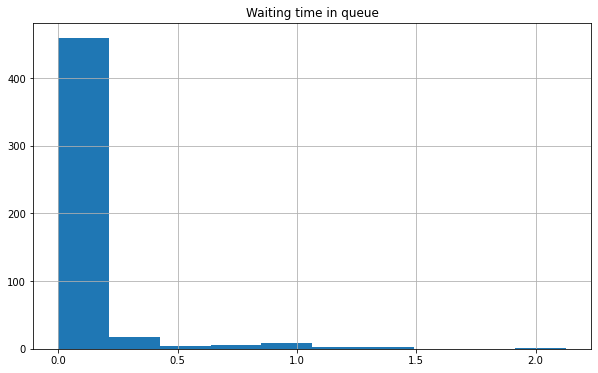

{'avTimeInQueue': 0.05859363773912309, 'probToWait': 0.096, 'probIdle': 0.0349033698895457, 'avServiceTime': 3.12, 'avTimeBetwArr': 0.9518579879676711, 'numOfCustWhoWait': 48, 'avTimeWhoWait': 0.6103503931158656, 'avTimeInTheSystem': 3.178593637739123}


In [7]:
import numpy as np
import pandas as pd
from scipy import stats as stts
import matplotlib.pyplot as plt
import random



plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (10, 6)

maxAngents = 500

arrival_min = 0.2
arrival_max = 1.5
arrival_rate = stts.uniform(loc = arrival_min, scale = arrival_max)
service_xk = np.arange(6) + 1.1
service_pk = (0.1, 0.2, 0.25, 0.3, 0.1, 0.05)
custm = stts.rv_discrete(name='custm', values=(service_xk, service_pk))

TOPRINT=True

S = DEVS()

# run simulation
AE = ArrivalEvent()
S.EQ.AddEvent(AE)

# --- SIMULATION ---
while S.EQ.QueueSize() > 0:
    S.ProcessNextEvent()

stat_dict = statistics(S, plot=True)
print(stat_dict)

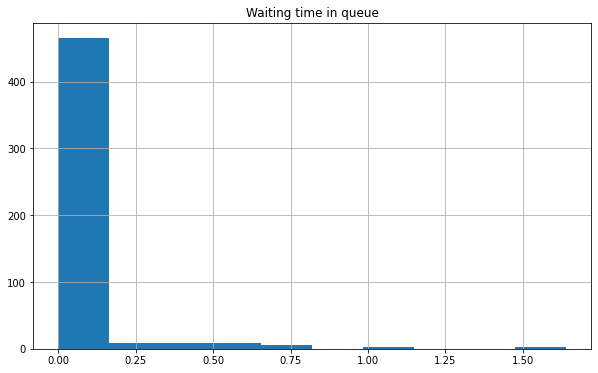

{'avTimeInQueue': 0.0429165294202873, 'probToWait': 0.098, 'probIdle': 0.030458813444386112, 'avServiceTime': 3.294, 'avTimeBetwArr': 0.9554887820550173, 'numOfCustWhoWait': 49, 'avTimeWhoWait': 0.43792376959476836, 'avTimeInTheSystem': 3.336916529420287}


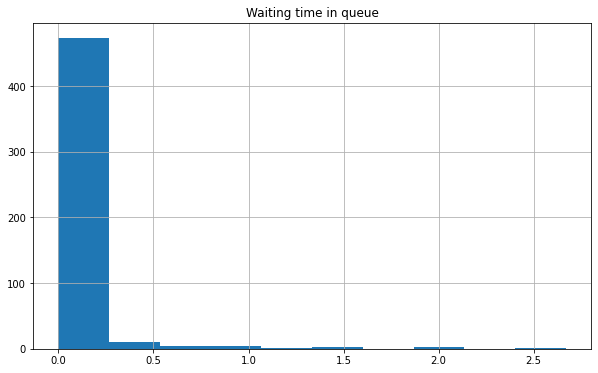

{'avTimeInQueue': 0.05169083947660045, 'probToWait': 0.082, 'probIdle': 0.035159718004896555, 'avServiceTime': 3.186, 'avTimeBetwArr': 0.935179636574853, 'numOfCustWhoWait': 41, 'avTimeWhoWait': 0.6303760911780543, 'avTimeInTheSystem': 3.2376908394766004}


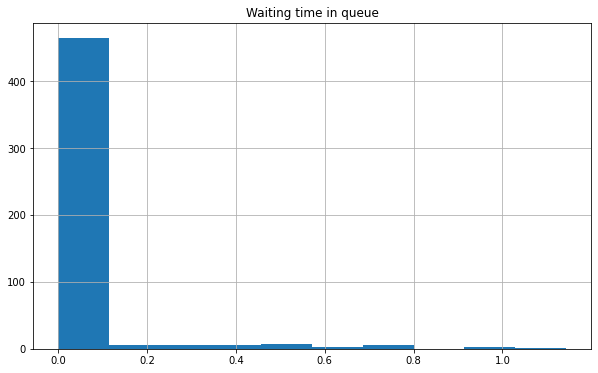

{'avTimeInQueue': 0.03508331805543195, 'probToWait': 0.086, 'probIdle': 0.03203878723432785, 'avServiceTime': 3.168, 'avTimeBetwArr': 0.9563153817817391, 'numOfCustWhoWait': 43, 'avTimeWhoWait': 0.4079455587840925, 'avTimeInTheSystem': 3.203083318055432}


In [8]:
TOPRINT=False

for i in range(3):
    S = DEVS()

    AE = ArrivalEvent()
    S.EQ.AddEvent(AE)
    while S.EQ.QueueSize() > 0:
        S.ProcessNextEvent()

    stat_dict = statistics(S, plot=True)
    print(stat_dict)

In [9]:
def mean_confidence_interval(data, eps=0.01, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m = np.mean(a)
    se = np.std(a, ddof=1) / np.sqrt(n)
    h = se * stts.t._ppf((1+confidence)/2.0, n-1)
    r = (stts.t._ppf((1+confidence)/2.0, n-1) * np.std(a, ddof=1) / eps)**2
    return m, h, r

In [10]:
# def getConfidenceLive(metric="avTimeWhoWait", eps_percent=1, row_num=5, max_iters=50):
#     stats_arr = []
#     for i in range(row_num):
#         S = DEVS()

#         AE = ArrivalEvent()
#         S.EQ.AddEvent(AE)
#         while S.EQ.QueueSize() > 0:
#             S.ProcessNextEvent()

#         stat_dict = statistics(S)
#         print(stat_dict)
#         stats_arr.append(stat_dict[metric])
    
#     stats_arr = np.array(stats_arr)
#     eps = eps_percent*stats.mean()/100 # 1% epsilon

#     start = len(stats_arr)

#     for i in range(max_iters):
#         m, h, r = mean_confidence_interval(stats_arr, eps=eps)
#         print(f"m: {m :.3f} h: {h :.3f} r: {int(r)} row_num: {row_num}")
#         if h <= eps:
#             break
#         else:
#             try:
#                 for j in range(r-row_num+1):
#                     S = DEVS()

#                     AE = ArrivalEvent()
#                     S.EQ.AddEvent(AE)
#                     while S.EQ.QueueSize() > 0:
#                         S.ProcessNextEvent()

#                     stat_dict = statistics(S)
#                     print(stat_dict)
#                     stats_arr = list(stats)
#                     stats_arr.append(stat_dict[metric])
#                     stats_arr = np.array(stats_arr)
#                 row_num += int(r+1)
#             except:
#                 print("ERROR")
#                 break

#     end = len(stats_arr)
#     print(f"eps: {eps :.3f}")
#     print(f"ans: {m :.3f}+-{h :.3f}")
#     print(f"R from: {start} to {end}")

In [11]:
# getConfidenceLive()

In [38]:
import time
start_time = time.time()

metric="avTimeInTheSystem"
eps_percent=0.5
row_num=5
max_iters=150
addition=2

stats_arr = []
for i in range(row_num):
    S = DEVS()
    AE = ArrivalEvent()
    S.EQ.AddEvent(AE)
    while S.EQ.QueueSize() > 0:
        S.ProcessNextEvent()
    stat_dict = statistics(S)
    stats_arr.append(stat_dict[metric])
    
stats_arr = np.array(stats_arr)
eps = eps_percent*stats_arr.mean()/100 # 1% epsilon

start = len(stats_arr)

for i in range(max_iters):
    m, h, r = mean_confidence_interval(stats_arr, eps=eps)
    if r > 1000:
        print("LARGE R REQUESTED")
        break
    if h <= eps:
        break
    else:
        print(f"m: {m :.3f} h: {h :.3f} r: {int(r)} num of exps: {len(stats_arr)}")
        try:
            for j in range(int(r)-len(stats_arr)+addition):
                S = DEVS()

                AE = ArrivalEvent()
                S.EQ.AddEvent(AE)
                while S.EQ.QueueSize() > 0:
                    S.ProcessNextEvent()

                stat_dict = statistics(S)
                stats_arr = list(stats_arr)
                stats_arr.append(stat_dict[metric])
                stats_arr = np.array(stats_arr)
        except Exception as e:
            print("ERROR")
            print(e)
            break

end = len(stats_arr)
print(f"eps: {eps :.3f}")
print(f"ans: {m :.3f}+-{h :.3f}")
print(f"R from: {start} to {end}")
print(time.time()-start_time)

m: 3.330 h: 0.033 r: 19 num of exps: 5
m: 3.309 h: 0.019 r: 28 num of exps: 21
m: 3.328 h: 0.021 r: 49 num of exps: 30
eps: 0.017
ans: 3.330+-0.017
R from: 5 to 51
6.603264808654785
